## Plotting the Losses

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

combined = False
# run_dir = './roman_runs/run10-swin-full-ss'
run_dir = '/home/shared/hsc/roman_lsst/lsst_runs/run7_sm_dlvl5/'
# run_dir = './roman_runs/run20-combined-swin'
if 'combined' in run_dir or '_roman' in run_dir:
    print("Using combined data")
    combined = True

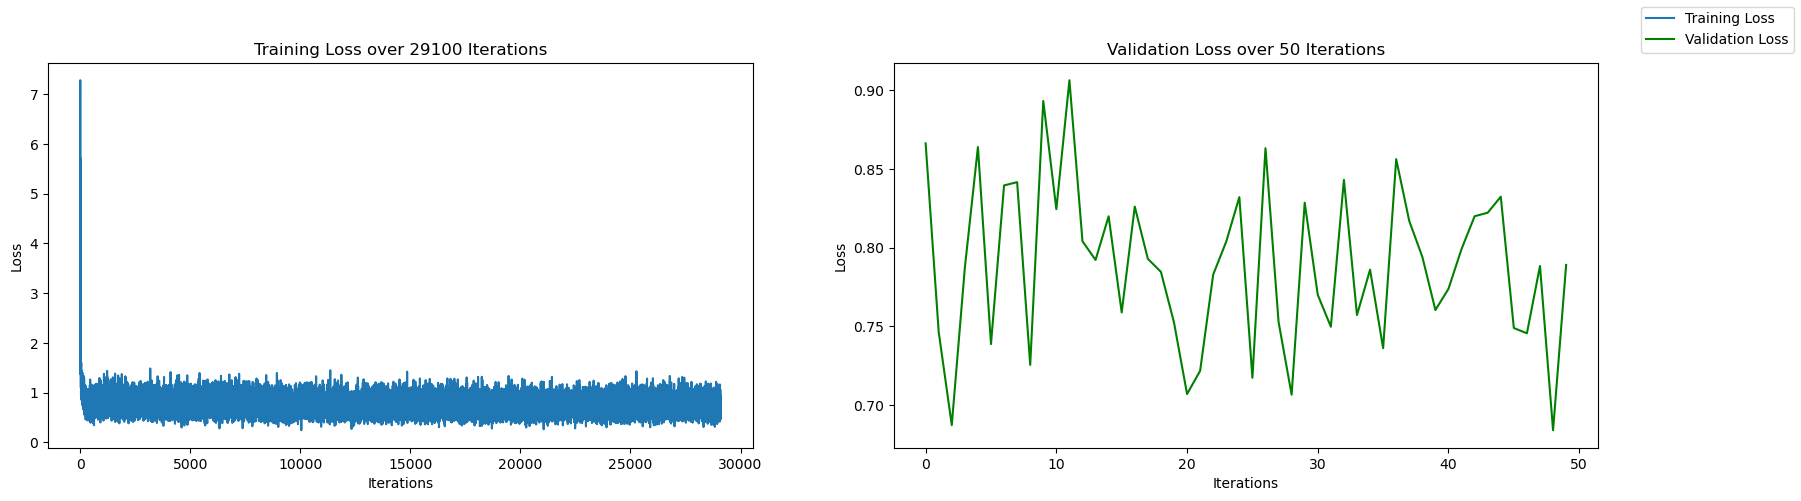

In [4]:
def plot_losses(run_name, run_dir):
    """ Plots the LossList and valLossList of trained model """
    train_loss_file = run_name + '_losses.npy'
    val_loss_file = run_name + '_val_losses.npy'
    train_loss_path = os.path.join(run_dir, train_loss_file)
    val_loss_path = os.path.join(run_dir, val_loss_file)
    train_losses = np.load(train_loss_path)
    val_losses = np.load(val_loss_path)
    fig, axes = plt.subplots(1, 2, figsize=(20,5))
    train_line = axes[0].plot(train_losses, label='Training Loss')
    axes[0].set_title(f'Training Loss over {train_losses.shape[0]} Iterations')
    val_line = axes[1].plot(val_losses, 'g', label='Validation Loss')
    axes[1].set_title(f'Validation Loss over {val_losses.shape[0]} Iterations')
    for ax in axes:
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Loss')
    fig.legend()
#     save plot to disk in same dir as run directory
    output_path = os.path.join(run_dir, "loss_plots.png")
    #plt.savefig(output_path)
    #print(f"Plots saved to {output_path}")
plot_losses('sm_dlvl5', run_dir)
#print(combined)

## Loading Config File for Predcitions

In [31]:
try:
    # ignore ShapelyDeprecationWarning from fvcore
    import warnings
    from shapely.errors import ShapelyDeprecationWarning
    warnings.filterwarnings("ignore", category=sShapelyDeprecationWarning)
except:
    pass
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

import gc
import os
import time

import detectron2.utils.comm as comm
import detectron2.data as d2data

# import some common libraries
import numpy as np
import torch
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2.config import LazyConfig, get_cfg

from deepdisc.data_format.image_readers import NumpyImageReader, ImageReader
from deepdisc.data_format.register_data import register_data_set
import deepdisc.model.loaders as loaders

# Hack if you get SSL certificate error
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# cfgfile = "./deepdisc/configs/solo/combined_swin_focal.py"
# cfgfile = "./deepdisc/configs/solo/combined_swin.py"
# cfgfile = "./deepdisc/configs/solo/solo_swin_dc2.py"
# cfgfile = "./deepdisc/configs/solo/solo_swin_Roman.py"
# cfgfile = "/home/shared/hsc/roman_lsst/deepdisc/configs/solo/swin_lsst.py" # for local
# cfgfile = "./deepdisc/configs/solo/swinc_lsst_ups.py"
cfgfile = "./configs/solo/swin_lsst_update.py" # when RunInference is in shared hsc folder under roman_lsst


# Load the config
cfg = LazyConfig.load(cfgfile)
for key in cfg.get("MISC", dict()).keys():
    cfg[key] = cfg.MISC[key]

## Running Inference

In [147]:
from deepdisc.data_format.image_readers import NumpyImageReader
from deepdisc.inference.predictors import AstroPredictor, get_predictions, get_predictions_new
import detectron2.checkpoint as checkpointer
from detectron2.data import MetadataCatalog, DatasetCatalog
import json, torch, glob

pth_files = glob.glob(os.path.join(run_dir, '*.pth'))
if pth_files:
    for pth in pth_files:
        if "instances" in pth: # ignore any instances.pth from evaluation 
            continue
        else:
            model_path = pth
    print(f"Using checkpoint file found in {run_dir}: {model_path}")

cfg.train.init_checkpoint = model_path # path to the model we just trained
for box_predictor in cfg.model.roi_heads.box_predictors:
    box_predictor.test_topk_per_image = 2000
    box_predictor.test_score_thresh = 0.2
    box_predictor.test_nms_thresh = 0.3

predictor = AstroPredictor(cfg)
# if combined:
#     with open('roman_data/annotations-combined/test_roman.json', 'r') as f:
#         data = json.load(f)
# else:
#     with open('roman_data/annotations/test_roman_ss.json', 'r') as f:
#         data = json.load(f)  

# try:
#     if combined:
#         test_roman = register_data_set('roman_test', 'roman_data/annotations-combined/test_roman.json', thing_classes=["galaxy", "star"])
#     else:
#         test_roman = register_data_set('roman_test', 'roman_data/annotations/test_roman_ss.json', thing_classes=["galaxy", "star"])        
# except AssertionError:
#     print("\nroman_test already registered!")    

# for lsst
# with open('/home/shared/hsc/roman_lsst/lsst_data/annotations/test.json', 'r') as f:
#     data = json.load(f)
# try:
#     test_roman = register_data_set('lsst_test', 'lsst_data/annotations/test.json', thing_classes=["galaxy", "star"])        
# except AssertionError:
#     print("\nlsst_test already registered!")   
with open('/home/shared/hsc/roman_lsst/lsst_data/annotations_lvl5/test.json', 'r') as f:
    data = json.load(f)
try:
    test_roman = register_data_set('lsst_test', '/home/shared/hsc/roman_lsst/lsst_data/annotations_lvl5/test.json', thing_classes=["galaxy", "star"])        
except AssertionError:
    print("\nlsst_test already registered!")


Using checkpoint file found in /home/shared/hsc/roman_lsst/lsst_runs/run7_sm_dlvl5/: /home/shared/hsc/roman_lsst/lsst_runs/run7_sm_dlvl5/sm_dlvl5.pth
[06/26 16:50:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /home/shared/hsc/roman_lsst/lsst_runs/run7_sm_dlvl5/sm_dlvl5.pth ...

lsst_test already registered!


19404


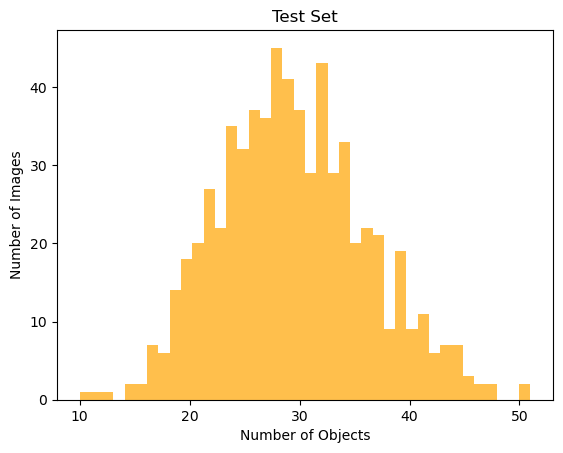

In [9]:
# hist of objects vs num of images in test set
objects = []
for d in data:
    objects.append(len(d['annotations']))
plt.hist(objects, bins=40, color='orange', alpha=0.7)
plt.xlabel('Number of Objects')
plt.ylabel('Number of Images')
plt.title('Test Set')
print(sum(objects))

In [92]:
class RomanImageReader(ImageReader):
    """An ImageReader for Roman image files."""

    def __init__(self, *args, **kwargs):
        # Pass arguments to the parent function.
        super().__init__(*args, **kwargs)

    def _read_image(self, filename):
        """Read the image.

        Parameters
        ----------
        filename : str
            The filename indicating the image to read.

        Returns
        -------
        im : numpy array
            The image.
        """
        image = np.load(filename) # (4, 512, 512)
        image = np.transpose(image, axes=(1, 2, 0)).astype(np.float32) # (512, 512, 4)
        return image
    
    
def roman_key_mapper(dataset_dict): # needs to return where the cutout image data for each cutout is stored 
    fn = os.path.join('/home/shared/hsc/roman_lsst',dataset_dict["file_name"][2:])
    return fn

def roman_truth_key_mapper(dataset_dict): # needs to return where the cutout image data for each cutout is stored 
    fprefix = os.path.join(*dataset_dict['file_name'][2:].split('/')[:-1])
    ftruth = f"truth{dataset_dict['file_name'][2:].split('/')[-1].split('full')[1]}"
    fpath = os.path.join(fprefix,ftruth).split('.npy')[0]
    fpath = fpath+'.json'
    
    fn = os.path.join('/home/shared/hsc/roman_lsst',fpath)
    return fn

reader = RomanImageReader()

In [ ]:
random_img

In [95]:
fprefix = os.path.join(*random_img['file_name'][2:].split('/')[:-1])
ftruth = f"truth{random_img['file_name'][2:].split('/')[-1].split('full')[1]}"
fpath = os.path.join(fprefix,ftruth).split('.npy')[0]
fpath = fpath+'.json'

fpath

'lsst_data/truth/dc2_52.49_-39.1/truth_c224_52.49_-39.1.json'

In [148]:
import random
# random.seed(15)
#random.seed(12)
# choose random image
random_idx = random.choice(range(len(data)))
print(random_idx)
random_img = None
# for d in data:
#     if d['file_name'] == './roman_data/truth/dc2_50.93_-42.0/full_c281_50.93_-42.0.npy':
#         random_img = d
#         break
# print(random_idx)
random_img = data[random_idx]
print(f"\n---- Running Inference on Random Image: test[{random_idx}] ----")
outputs = get_predictions(random_img, reader, roman_key_mapper, predictor)
total_instances = len(random_img["annotations"])
det_instances = outputs["instances"]
print("\nTotal instances (star or galaxy) in image:", total_instances)
print("Detected instances: ", len(det_instances.pred_classes))
print("Detected instances of galaxies: ", (det_instances.pred_classes == 0).sum().item())
print("Detected instances of stars: ", (det_instances.pred_classes == 1).sum().item())

280

---- Running Inference on Random Image: test[280] ----

Total instances (star or galaxy) in image: 12
Detected instances:  15
Detected instances of galaxies:  15
Detected instances of stars:  0


In [145]:
import matplotlib.colors as colors

try:
    custom_colors = [
    #     (255, 0, 0),    # Red
        (0, 255, 0),    # Green
        (0, 0, 255),    # Blue
#         (255, 255, 0),  # Yellow
    #     (255, 165, 0),  # Orange
    #     (255, 0, 255),  # Magenta
    #     (0, 255, 255),  # Cyan
    ]
    test_roman.set(thing_classes=["galaxy", "star"]).set(thing_colors=custom_colors)
#     test_roman.thing_colors = custom_colors
except AssertionError:
    # test_roman.thing_colors = custom_colors
    print("\colors already registered!")  

Setting colors


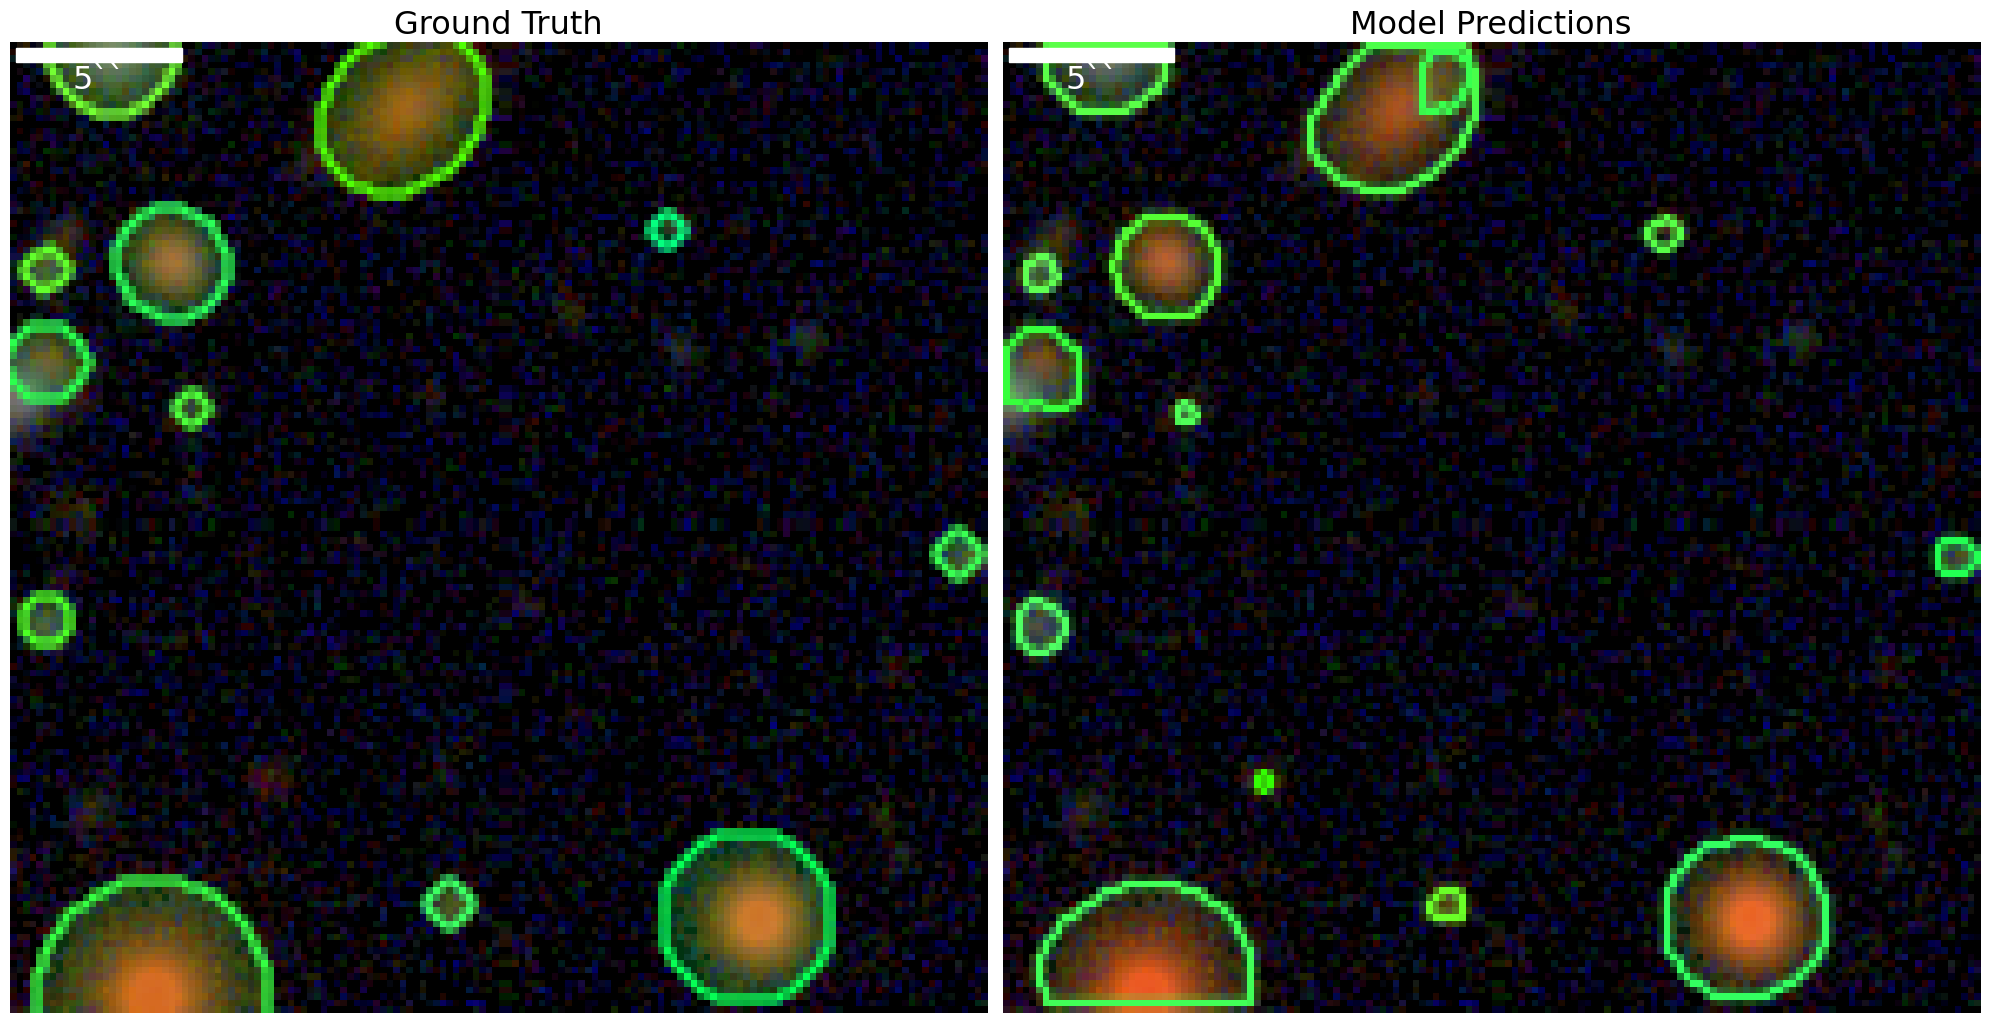

In [149]:
from deepdisc.astrodet.visualizer import Visualizer
from deepdisc.astrodet.visualizer import ColorMode
from astropy.visualization import make_lupton_rgb
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=23)

key = roman_key_mapper(random_img)
img = reader._read_image(key)
# img = make_lupton_rgb(img[:,:,2], img[:,:,3], img[:,:,4], minimum=0, stretch=50, Q=10)
img = make_lupton_rgb(img[:,:,2], img[:,:,1], img[:,:,0], minimum=0, stretch=0.5, Q=10)
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
for ax in axes:
    ax.axis("off")


v_gt = Visualizer(
    img.copy(),
    metadata=test_roman,
    scale=1,
    instance_mode=ColorMode.SEGMENTATION,
)
axes[0].set_title("Ground Truth", fontsize=23)
# print(random_img['file_name'])
ground_truth = v_gt.draw_dataset_dict(random_img, lf=False,alpha=0.2, boxf=False)
axes[0].imshow(ground_truth.get_image())

v = Visualizer(
    img,
    metadata=test_roman,
    scale=1,
    instance_mode=ColorMode.SEGMENTATION,  # remove the colors of unsegmented pixels. This option is only available for segmentation models
)

axes[1].set_title("Model Predictions",fontsize=23)
prediction_output = v.draw_instance_predictions(outputs["instances"].to("cpu"), alpha=0.1,lf=False)
axes[1].imshow(prediction_output.get_image())

scalebar = AnchoredSizeBar(axes[0].transData,
                           25, '5``', 'upper left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=2,
                           fontproperties=fontprops)

axes[0].add_artist(scalebar)


scalebar = AnchoredSizeBar(axes[1].transData,
                           25, '5``', 'upper left', 
                           pad=0.1,
                           color='white',
                           frameon=False,
                           size_vertical=2,
                           fontproperties=fontprops)

axes[1].add_artist(scalebar)

# axes[1].scatter(175.618416,247.179605,color='w',s=5)

plt.tight_layout()

# save if needed
#output_path = os.path.join(run_dir, f"det_gt_{random_idx}.png")
#plt.savefig(output_path)
#print(f"Plots saved to {output_path}")

In [134]:
ftruth

'/home/shared/hsc/roman_lsst/lsst_data/truth/dc2_52.49_-39.1/truth_c224_52.49_-39.1.json'

In [100]:
ftruth = roman_truth_key_mapper(random_img)

with open(ftruth, 'r') as f:
    truth_data = json.load(f)

In [121]:
cs = outputs["instances"].pred_boxes.get_centers().cpu().numpy()
xs = cs[:,0]
ys = cs[:,1]

In [123]:
xst =  [obj['cutout_x'] for obj in truth_data]
yst =  [obj['cutout_y'] for obj in truth_data]

xstcut =  [obj['cutout_x'] for obj in truth_data if obj['mag_i']<26.3]
ystcut =  [obj['cutout_y'] for obj in truth_data if obj['mag_i']<26.3]

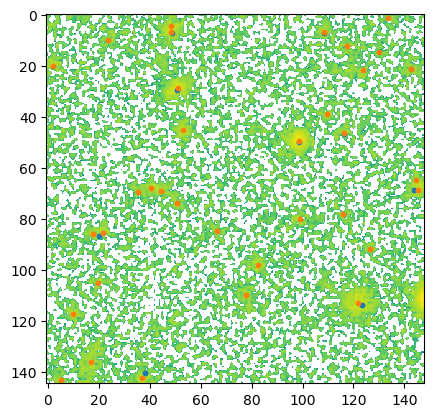

In [130]:
key = roman_key_mapper(random_img)
img = reader._read_image(key)

plt.imshow(img[:,:,3],norm=colors.LogNorm())
plt.scatter(xs,ys,s=10)
#plt.scatter(xst,yst,s=10,marker='x')
plt.scatter(xstcut,ystcut,s=10)

# 

## Evaluating Model using Different Metrics

In [6]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog
from deepdisc.data_format.register_data import register_data_set
from detectron2 import structures
from detectron2.structures import BoxMode
import pandas as pd
import seaborn as sns
import deepdisc.astrodet.astrodet as toolkit

In [4]:
try:
    test_roman_nc = register_data_set('roman_test_c', 'roman_data/annotations-combined/test_roman.json', thing_classes=["galaxy", "star"])
except AssertionError:
    print("roman_test_c already registered!")  

In [5]:
with open('roman_data/annotations-combined/test_roman.json', 'r') as f:
    data_c = json.load(f)  

In [7]:
from deepdisc.model.loaders import return_test_loader, return_train_loader
mapper = cfg.dataloader.train.mapper(
    cfg.dataloader.imagereader, roman_key_mapper
).map_data
# evaluator = toolkit.COCOEvaluatorRecall('roman_test', use_fast_impl=True, output_dir=run_dir, allow_cached_coco=False)
# eval_loader = d2data.build_detection_test_loader(cfg, 'roman_test', mapper=mapper)
evaluator = toolkit.COCOEvaluatorRecall('lsst_test', use_fast_impl=True, output_dir=run_dir, allow_cached_coco=False)
eval_loader = d2data.build_detection_test_loader(cfg, 'lsst_test', mapper=mapper)
results = inference_on_dataset(predictor.model, eval_loader, evaluator)
# results

Loading  /home/shared/hsc/roman_lsst/lsst_runs/run4_ups_roman/lsst_test_coco_format.json
[09/24 11:35:54 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   galaxy   | 18989        |    star    | 415          |
|            |              |            |              |
|   total    | 19404        |            |              |
[09/24 11:35:54 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/24 11:35:54 d2.data.common]: Serializing 658 elements to byte tensors and concatenating them all ...
[09/24 11:35:54 d2.data.common]: Serialized dataset takes 3.04 MiB
[09/24 11:35:54 d2.evaluation.evaluator]: Start inference on 658 batches
[09/24 11:36:00 d2.evaluation.evaluator]: Inference done 1/658. Dataloading: 0.5283 s/iter. Inference: 5.6863 s/iter. Eval: 0.0973 s/iter. Total: 6.3150 s/iter. ETA=1:09:08
[09

In [8]:
def plot_ap(classes, results_per_category, recalls_per_category, run_dir, ap_type):
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))
    axs = axs.flatten()
    
    ious = np.linspace(0.50, 0.95, 10)
    colors = plt.cm.viridis(np.linspace(0, 1, len(ious)))
    labels = []
    
    # Plot precision recall
    for j, (precision_class, recall_class) in enumerate(zip(results_per_category, recalls_per_category)):
        precision_shape = np.shape(precision_class)
        
        for i in range(precision_shape[0]):
            # precision has dims (iou, recall, cls, area range, max dets)
            # recall has dims (iou, cls, area range, max dets)
            # area range index 0: all area ranges
            # max dets index -1: typically 100 per image
            p_dat = precision_class[i, :, j, 0, -1]
            r_dat = recall_class[i, j, 0, -1]
            # Hide vanishing precisions
            mask = p_dat > 0
            # Only keep first occurance of 0 value in array
            mask[np.cumsum(~mask) == 1] = True
            p = p_dat[mask]
            # Recall points
            r = np.linspace(0, 1, len(p))  # Recall is always defined from 0 to 1
            dr = np.diff(np.linspace(0, 1, len(p_dat)))[0]  # i think
            # Plot
            iou = np.around(ious[i], 2)
            AP = 100 * np.sum(p * dr)
            AR = 100 * r_dat
            label = f"$AP_{{{iou:.2f}}} = {AP:.1f}, AR_{{{iou:.2f}}} = {AR:.1f}$"
            labels.append(label)
            axs[j].plot(
                r, p, label=label, color=colors[i], lw=2
            )  # use a viridis color scheme
            axs[j].set_xlabel("Recall", fontsize=20)
            axs[j].set_ylabel("Precision", fontsize=20)
            axs[j].set_xlim(0, 1.1)
            axs[j].set_ylim(0, 1.1)
            axs[j].legend(fontsize=10, title=f"{classes[j]}", bbox_to_anchor=(1.35, 1.0))
    fig.suptitle(f'AP Scores - {ap_type}', fontsize=16)
    fig.tight_layout()
    output_path = os.path.join(run_dir, f"AP_precision_recall_{ap_type}.png")
#     plt.savefig(output_path)
    print(f"Plots saved to {output_path}")
#     print(labels)

# if len(outputs["instances"].pred_boxes) != 0:
#         print("\nAP Score by Class for BBox")
#         print("------------------")
#         print(f"galaxy: {results['bbox']['AP-galaxy']}\nstar: {results['bbox']['AP-star']}")
#         print("\nAP Score by Class for Segm")
#         print("------------------")
#         print(f"galaxy: {results['segm']['AP-galaxy']}\nstar: {results['segm']['AP-star']}")
#         with open(f'{run_dir}/ap_scores_test{random_idx}.txt', 'w') as f:
#             f.write("\nAP Score by Class for BBox")
#             f.write(f"\ngalaxy: {results['bbox']['AP-galaxy']}\nstar: {results['bbox']['AP-star']}")
#             f.write("\nAP Score by Class for Segm")
#             f.write(f"\ngalaxy: {results['segm']['AP-galaxy']}\nstar: {results['segm']['AP-star']}")
#         print(f"AP Scores saved to {run_dir}/ap_scores_test{random_idx}.txt")

--- For run2 that included no-match class ---

As we can see, the low precision for detecting stars and the high number of false positives for stars have a significant impact on the overall precision of the detections despite having high precision for galaxies. One cause could be the extremely imbalanced dataset as this data mainly consists of many more galaxies than stars.

In [14]:
import pickle
with open(f'{run_dir}/all_matched_gts.pkl', 'wb') as f:
    pickle.dump(all_matched_gts, f)

## V1 Mags vs Metrics Plots (Takes a lot of time)

In [15]:
# find all metrics vs mags
mag_metrics = find_metric_v_mag(data, reader, predictor, roman_key_mapper, mag_types=['mag_i'], num_bins=10)

In [17]:
mag_metrics

{'mag_i': {'bins': array([10.4798975 , 12.02191267, 13.56392784, 15.10594301, 16.64795818,
         18.18997335, 19.73198853, 21.2740037 , 22.81601887, 24.35803404,
         25.90004921]),
  'metrics': [           Galaxy  Star  Overall  Detection
   Precision     NaN   1.0      NaN   0.000142
   Recall        NaN   1.0      NaN   0.000164
   F1-Score      NaN   1.0      NaN   0.000153,
              Galaxy  Star  Overall  Detection
   Precision     NaN   1.0      NaN   0.000071
   Recall        NaN   1.0      NaN   0.000082
   F1-Score      NaN   1.0      NaN   0.000076,
              Galaxy  Star  Overall  Detection
   Precision     NaN   1.0      NaN   0.000356
   Recall        NaN   1.0      NaN   0.000411
   F1-Score      NaN   1.0      NaN   0.000382,
              Galaxy  Star  Overall  Detection
   Precision     NaN   1.0      NaN   0.000712
   Recall        NaN   1.0      NaN   0.000822
   F1-Score      NaN   1.0      NaN   0.000763,
                Galaxy      Star   Overall  

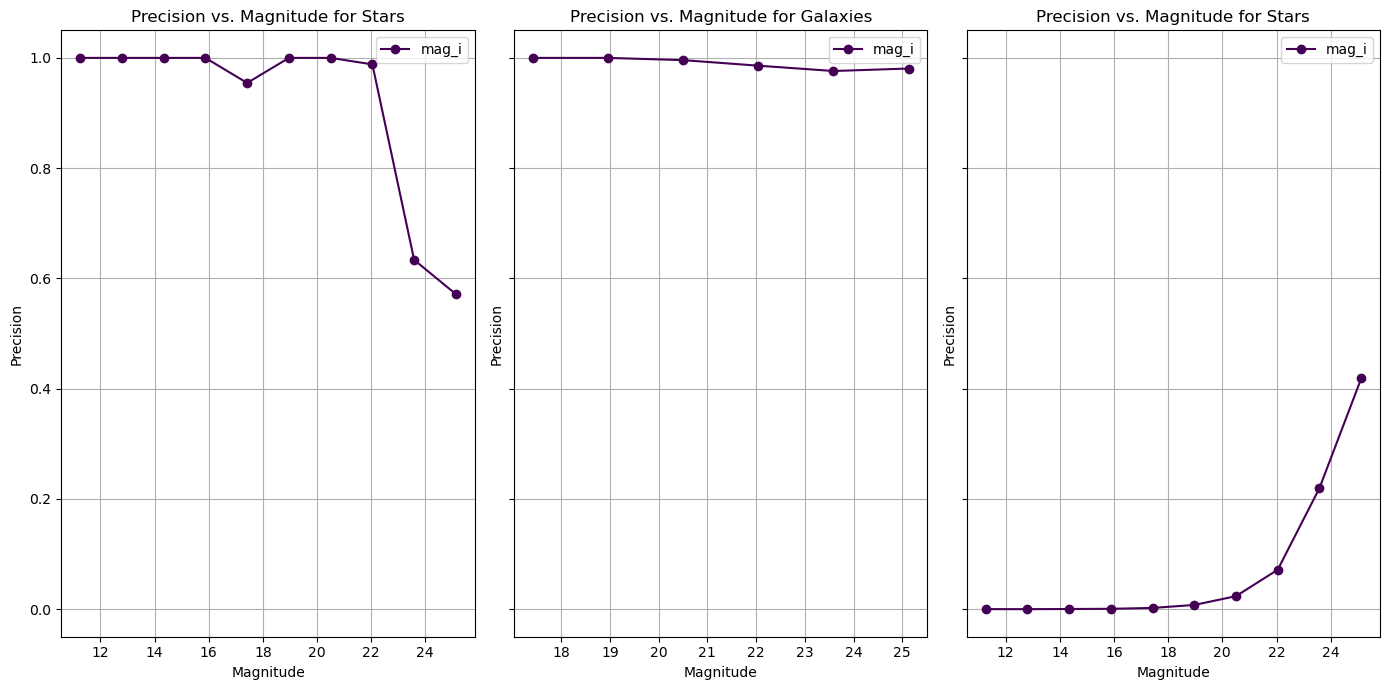

In [21]:
plot_metric_v_mag(mag_metrics, "Rec", run_dir)

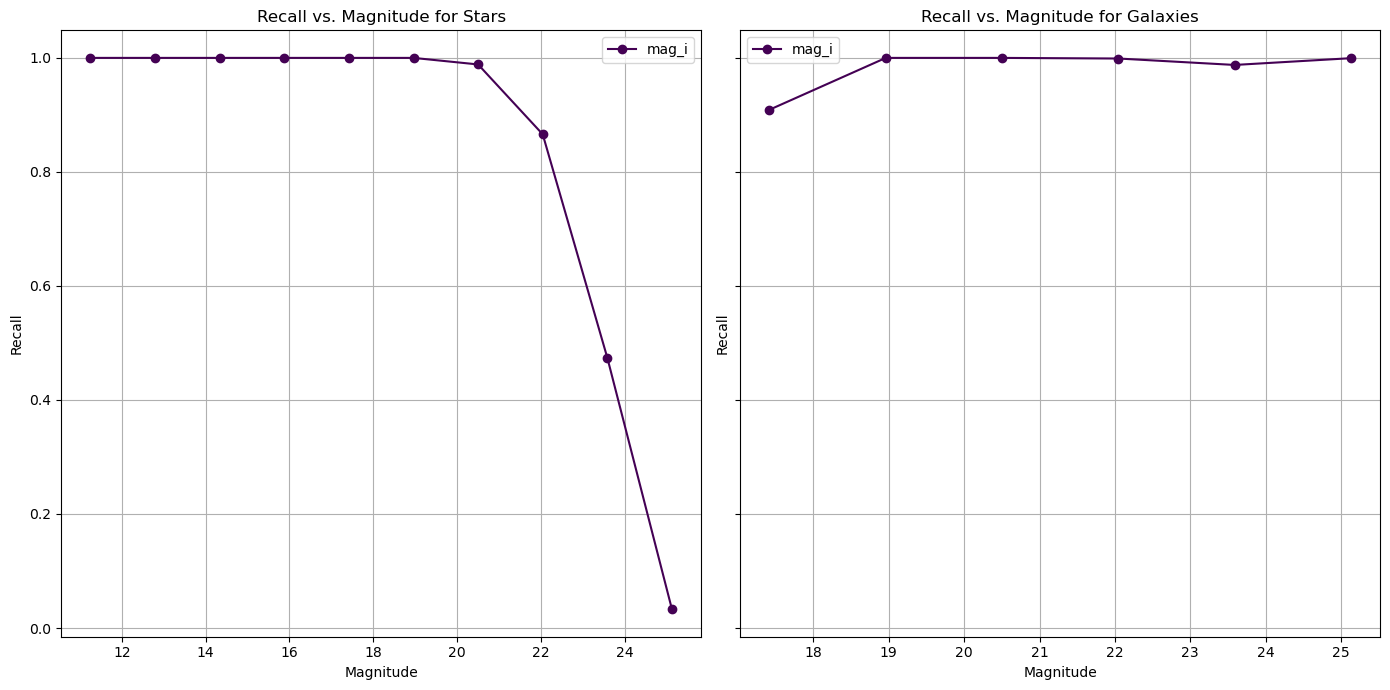

In [60]:
plot_metric_v_mag(mag_metrics, "Recall", run_dir)

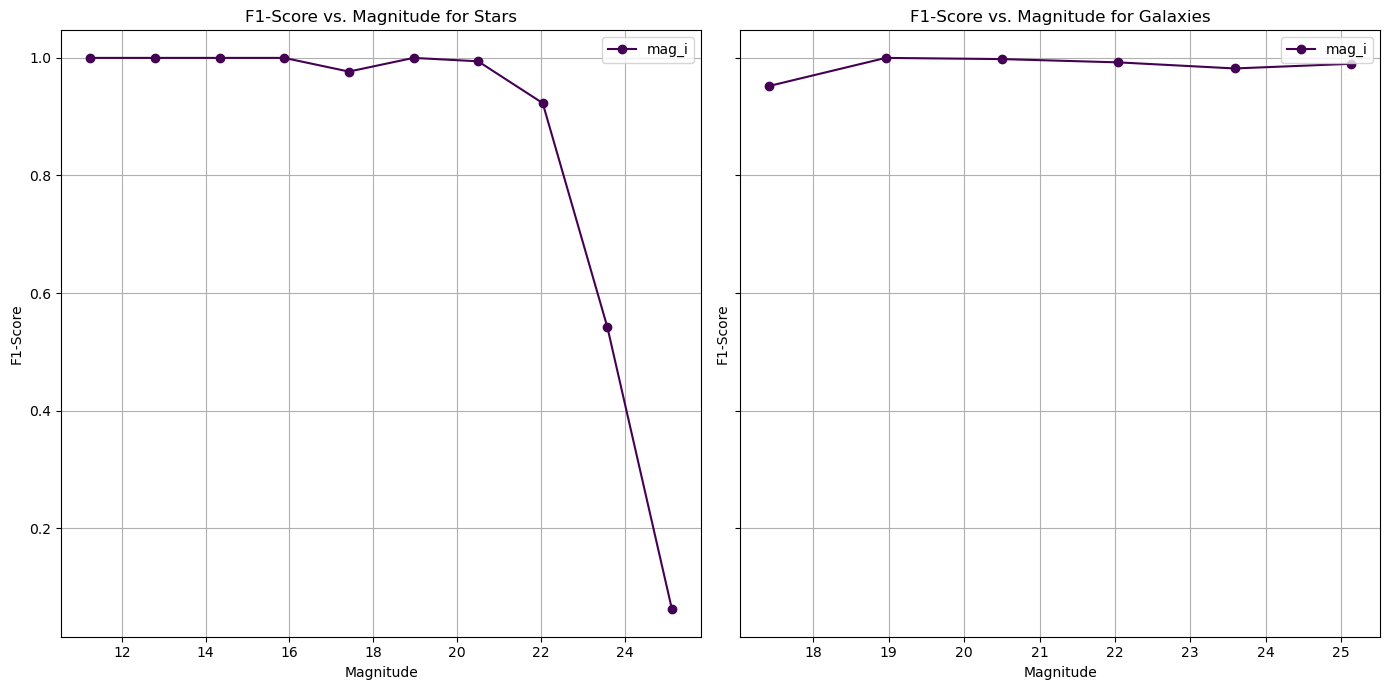

In [61]:
plot_metric_v_mag(mag_metrics, "F1-Score", run_dir)

In [53]:
metrics_data = find_metricsv2(results)

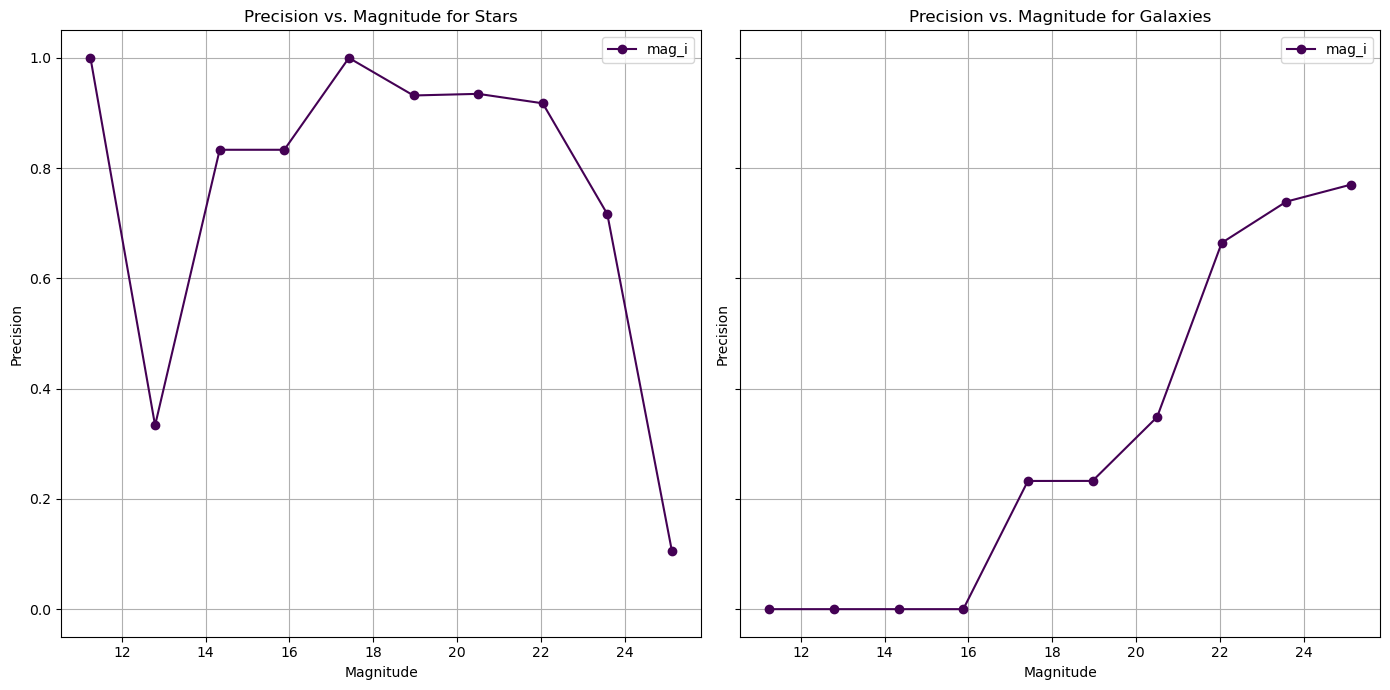

In [54]:
plot_metric_v_magv2(metrics_data, 'Precision', run_dir)

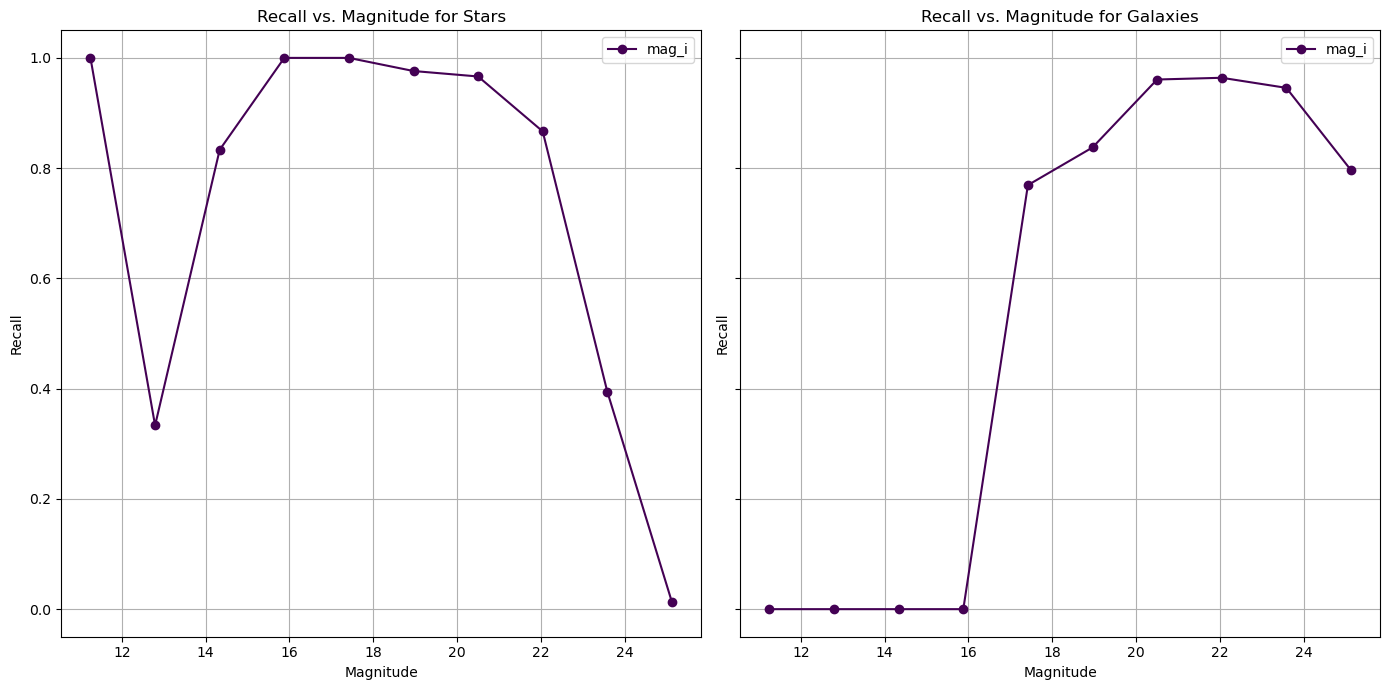

In [55]:
plot_metric_v_magv2(metrics_data, 'Recall', run_dir)

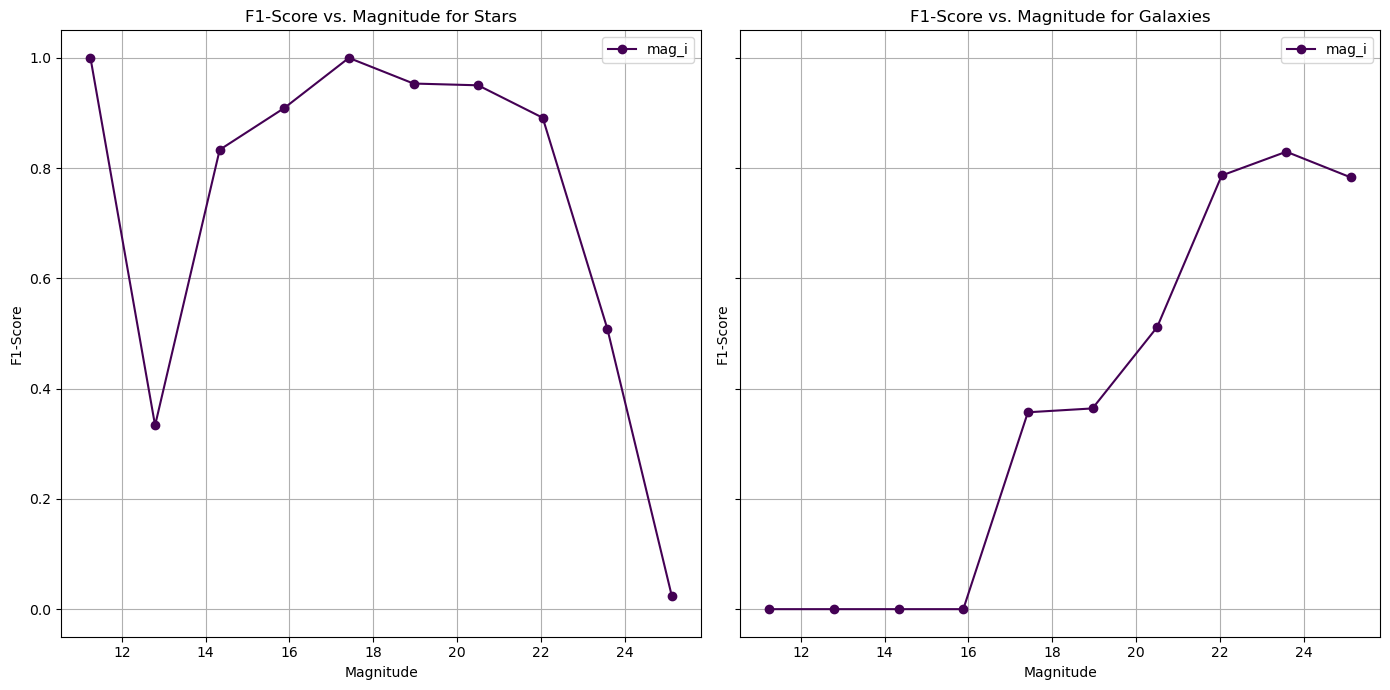

In [56]:
plot_metric_v_magv2(metrics_data, 'F1-Score', run_dir)

In [27]:
# def process_single_image(d, imreader, predictor, key_mapper, mag_types, mag_bins):
#     outputs = get_predictions(d, imreader, key_mapper, predictor)
#     results = {mag_type: {i: {'TP': 0, 'FP': 0, 'FN': 0} for i in range(len(mag_bins[mag_type]) - 1)} for mag_type in mag_types}
    
#     gt_boxes = np.array([a["bbox"] for a in d["annotations"]])
#     if gt_boxes.shape[0] == 0:
#         return results

#     gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
#     gt_boxes = structures.Boxes(torch.Tensor(gt_boxes))
#     pred_boxes = outputs["instances"].pred_boxes.to("cpu")
#     IOUs = structures.pairwise_iou(pred_boxes, gt_boxes).numpy()
    
#     for mag_type in mag_types:
#         for i, (gt, iou_row) in enumerate(zip(d['annotations'], IOUs.T)):
#             mag = gt[mag_type]
#             if mag == 0:
#                 continue
#             bin_index = np.digitize(mag, mag_bins[mag_type]) - 1
            
#             if iou_row.max() >= 0.5:  # IOU threshold
#                 results[mag_type][bin_index]['TP'] += 1
#             else:
#                 results[mag_type][bin_index]['FN'] += 1
        
#         for iou_row in IOUs:
#             if iou_row.max() < 0.5:  # IOU threshold
#                 bin_index = np.digitize(mag, mag_bins[mag_type]) - 1
#                 results[mag_type][bin_index]['FP'] += 1
    
#     return results

from collections import defaultdict

def pr_mag(test_data, imreader, predictor, key_mapper, mag_type='fmag', bin_width=0.3):
    class_names = ['galaxy', 'star']
    mag_bins = {cls: defaultdict(lambda: {'TP': 0, 'FP': 0}) for cls in class_names}
    
    for d in test_data:
        outputs = get_predictions(d, imreader, key_mapper, predictor)
        IOUthresh = 0.5
        gt_boxes = np.array([ann["bbox"] for ann in d["annotations"] if ann[mag_type] != 0])
        gt_mags = np.array([ann[mag_type] for ann in d["annotations"] if ann[mag_type] != 0])
        gt_classes = np.array([ann["category_id"] for ann in d["annotations"] if ann[mag_type] != 0])
        
        if gt_boxes.shape[0] != 0:
            gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            gt_boxes = structures.Boxes(torch.Tensor(gt_boxes))
            pred_boxes = outputs["instances"].pred_boxes.to("cpu")
            pred_classes = outputs["instances"].pred_classes.cpu().numpy()
            IOUs = structures.pairwise_iou(pred_boxes, gt_boxes).numpy()
            
            for i, dt in enumerate(IOUs):
                pred_mag = gt_mags[dt.argmax()]  # mag of the best matching ground truth
                pred_class = class_names[pred_classes[i]]
                bin_index = int(pred_mag / bin_width)
#                 bin_index = pred_mag - (pred_mag % bin_width)
                if dt.max() >= IOUthresh:
                    if pred_class == class_names[gt_classes[dt.argmax()]]:
                        mag_bins[pred_class][bin_index]['TP'] += 1
                    else:
                        mag_bins[pred_class][bin_index]['FP'] += 1
                else:
                    mag_bins[pred_class][bin_index]['FP'] += 1
    
    for cls in class_names:
        # find precision for each mag bin
        mags = sorted(mag_bins[cls].keys())
        precisions = []

        for mag in mags:
            TP = mag_bins[cls][mag]['TP']
            FP = mag_bins[cls][mag]['FP']
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            precisions.append(precision)

        # convert bin indices back to actual magnitudes
        magnitudes = [m * bin_width for m in mags]
    #     return precisions, magnitudes

        plt.figure(figsize=(10, 6))
        plt.plot(magnitudes, precisions, marker='o')
        plt.xlabel(f'Magnitude ({mag_type})')
        plt.ylabel('Precision')
        plt.title(f'{cls.capitalize()} Precision vs Magnitude')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.ylim(0, 1.05)


# def get_pr(test_data, imreader, predictor, key_mapper, mag_type, by_mag=True, flow=0, fhigh=30):
#     TP=FN=FP=0
#     TP_classes = np.array([0,0])
#     pred_tots = np.array([0,0]) # holds number of detected objs for each class
#     gt_tots = np.array([0,0]) # holds number of true objs for each class
    
#     all_matched_gts = []
#     all_matched_dts = []
#     cls_ids = [0,1]
#     for d in test_data:
#         outputs = get_predictions(d, imreader, key_mapper, predictor)
#         IOUthresh = 0.5
#         gt_boxes = np.array([a["bbox"] for a in d["annotations"]])
#         # Convert to the mode model expects
#         # Make sure the input bboxes are in XYWH mode so they can be converted here
#         if gt_boxes.shape[0] != 0: # as some images don't have any annotation or no preds from the model
#             gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
#             gt_boxes = structures.Boxes(torch.Tensor(gt_boxes))
#             pred_boxes = outputs["instances"].pred_boxes.to("cpu")
#             IOUs = structures.pairwise_iou(pred_boxes, gt_boxes).numpy()
#             # matched_gts holds the indices of the ground truth annotations that correspond to the matched detections
#             # matched_dts holds the indices of the detections that corresponds to the ground truth annotations
#             matched_gts = []
#             matched_dts =[]
#             for i, dt in enumerate(IOUs):
#                 # might allow a gt box to match with multiple preds if those preds have highest IoU with same gt box
#                 # leads to double-counting unless handled to ensure that once a ground truth box is matched, not considered for further matches
#                 IOU = dt[dt.argmax()]
#                 mag = d['annotations'][dt.argmax()][mag_type]
#                 if by_mag:
# #                 #considered a true detection if above the threshold
#                     if IOU>=IOUthresh and mag>=flow and mag<fhigh:
#                         matched_gts.append(dt.argmax())
#                         matched_dts.append(i)
#                 else:
#                     if IOU>=IOUthresh:
#                         matched_gts.append(dt.argmax())
#                         matched_dts.append(i)                         
#             all_matched_gts.append(set(matched_gts))
#             all_matched_dts.append(set(matched_dts))
                
#             TP += len(matched_gts)
#             # num of gt boxes - matched num of gt boxes that were matched w/ pred boxes
#             # account for gt boxes that didn't match any pred boxes
#             FN += (IOUs.shape[1] - len(set(matched_gts)))
#             # num of pred boxes - matched num of dt that were matched w/ gt boxes
#             # account for the preds that didn't match any ground truth boxes
#             FP += (IOUs.shape[0] - len(set(matched_dts))) 

#             for gti, dti in zip(matched_gts, matched_dts):
#                 class_gt = d['annotations'][gti]['category_id']
#                 class_dt = outputs['instances'][dti].pred_classes.cpu().detach().numpy()
#                 for ci, c in enumerate(cls_ids):
#                     if class_gt == class_dt == c:
#                         TP_classes[ci] += 1
#                     if class_dt == c:
#                         pred_tots[ci] += 1
#                     if class_gt == c:
#                         gt_tots[ci] += 1
    
#     # calc of the below are correct
#     FP_classes = pred_tots - TP_classes
#     FN_classes = gt_tots - TP_classes
#     # metrics[0] is assuming galaxy as pos example and star as neg example whereas metrics[1] is vice versa
#     precision_classes = TP_classes / (TP_classes + FP_classes)
#     recall_classes = TP_classes / (TP_classes + FN_classes)
#     f1_classes = 2 * (precision_classes * recall_classes) / (precision_classes + recall_classes)
    
#     # macro averaging to obtain overall performance (unweighted mean to treat all classes equally)
#     avg_precision = precision_classes.mean()
#     avg_recall = recall_classes.mean()
#     avg_f1_score = f1_classes.mean()
    
#     metrics = pd.DataFrame({ "Galaxy": [precision_classes[0], recall_classes[0], f1_classes[0]],
#                        "Star": [precision_classes[1], recall_classes[1], f1_classes[1]],
#                        "Overall": [avg_precision, avg_recall, avg_f1_score]
#                       }, index=['Precision','Recall', 'F1-Score'])
    
#     return metrics


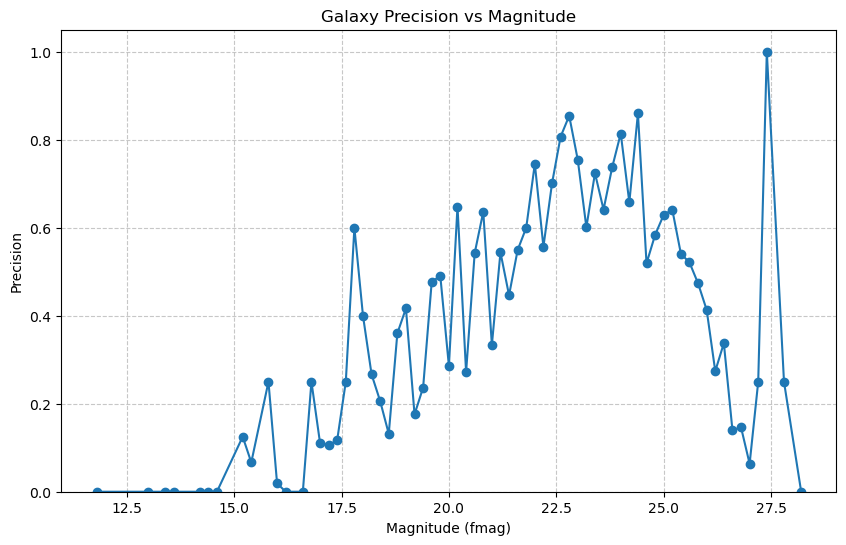

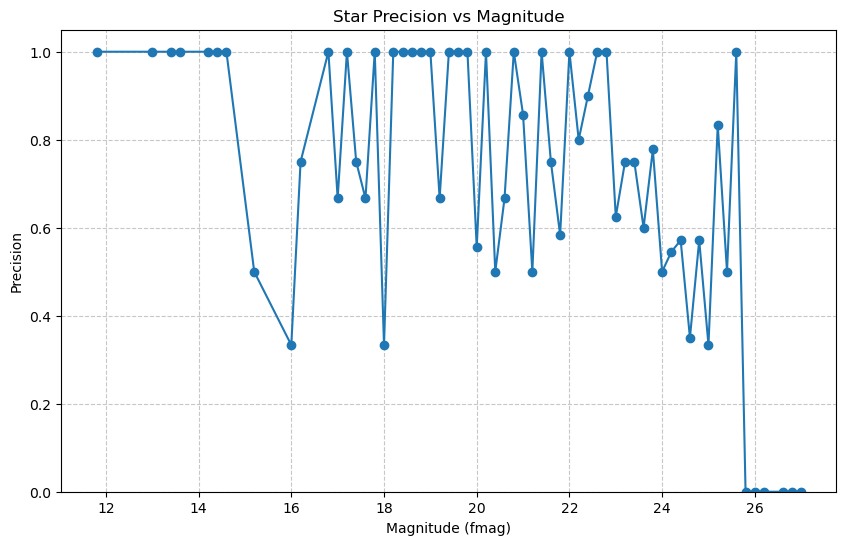

In [32]:
# mag_metrics = find_metric_v_magv2(data, reader, predictor, roman_key_mapper, mag_types=['fmag', 'ymag', 'jmag', 'hmag'])
pr_mag(data, reader, predictor, roman_key_mapper, mag_type='fmag', bin_width=0.2)

In [13]:
from detectron2 import structures
from detectron2.structures import BoxMode
import pandas as pd
from collections import defaultdict
import seaborn as sns
def get_metricsv2(test_data, imreader, predictor, key_mapper, mag_type='fmag', by_mag=False, flow=0, fhigh=30):
    TP=FN=FP=0
    TP_classes = np.array([0,0])
    pred_tots = np.array([0,0]) # holds number of detected objs for each class
    gt_tots = np.array([0,0]) # holds number of true objs for each class
    confusion_matrix = np.zeros((2, 2), dtype=int)
    
    mag_bins = np.arange(12, 30, 1)  # Adjust this range as needed
   
    TP_by_class_mag = {0: defaultdict(int), 1: defaultdict(int)}  # 0 for galaxy, 1 for star
    pred_tots_by_class_mag = {0: defaultdict(int), 1: defaultdict(int)}
    gt_tots_by_class_mag = {0: defaultdict(int), 1: defaultdict(int)}
    
    all_matched_gts = []
    all_matched_dts = []
    cls_ids = [0,1]
#     total_stars = total_galaxies = 0
    for d in test_data:
        outputs = get_predictions(d, imreader, key_mapper, predictor)
        IOUthresh = 0.5
        gt_boxes = np.array([a["bbox"] for a in d["annotations"]])
        # Convert to the mode model expects
        # Make sure the input bboxes are in XYWH mode so they can be converted here
        if gt_boxes.shape[0] != 0: # as some images don't have any annotation or no preds from the model
            gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
            gt_boxes = structures.Boxes(torch.Tensor(gt_boxes))
            pred_boxes = outputs["instances"].pred_boxes.to("cpu")
            IOUs = structures.pairwise_iou(pred_boxes, gt_boxes).numpy()
            # matched_gts holds the indices of the ground truth annotations that correspond to the matched detections
            # matched_dts holds the indices of the detections that corresponds to the ground truth annotations
            matched_gts = []
            matched_dts =[]
            for i, dt in enumerate(IOUs):
                # might allow a gt box to match with multiple preds if those preds have highest IoU with same gt box
                # leads to double-counting unless handled to ensure that once a ground truth box is matched, not considered for further matches
                IOU = dt[dt.argmax()]
                mag = d['annotations'][dt.argmax()][mag_type]
                if by_mag:
#                 #considered a true detection if above the threshold
                    if IOU>=IOUthresh and mag>=flow and mag<fhigh:
                        matched_gts.append(dt.argmax())
                        matched_dts.append(i)
                else:
                    if IOU>=IOUthresh:
                        matched_gts.append(dt.argmax())
                        matched_dts.append(i)                         
#                 matched_gts.append(dt.argmax())
#                 matched_dts.append(i)
                        
            all_matched_gts.append(set(matched_gts))
            all_matched_dts.append(set(matched_dts))
                
            TP += len(matched_gts)
            # num of gt boxes - matched num of gt boxes that were matched w/ pred boxes
            # account for gt boxes that didn't match any pred boxes
            FN += (IOUs.shape[1] - len(set(matched_gts)))
            # num of pred boxes - matched num of dt that were matched w/ gt boxes
            # account for the preds that didn't match any ground truth boxes
            FP += (IOUs.shape[0] - len(set(matched_dts))) 

            for gti, dti in zip(matched_gts, matched_dts):
                class_gt = d['annotations'][gti]['category_id']
                class_dt = outputs['instances'][dti].pred_classes.cpu().detach().numpy()
                confusion_matrix[class_gt, class_dt] += 1
                for ci, c in enumerate(cls_ids):
                    if class_gt == class_dt == c:
                        TP_classes[ci] += 1
                    if class_dt == c:
                        pred_tots[ci] += 1
                    if class_gt == c:
                        gt_tots[ci] += 1
            
            for gti in range(len(d['annotations'])):
                class_gt = d['annotations'][gti]['category_id']
                mag = d['annotations'][gti][mag_type]
                mag_bin = np.digitize(mag, mag_bins) - 1
                gt_tots_by_class_mag[class_gt][mag_bin] += 1

                if gti in set(matched_gts):
                    dti = matched_dts[matched_gts.index(gti)]
                    class_dt = outputs['instances'][dti].pred_classes.cpu().detach().numpy().item()
                    pred_tots_by_class_mag[class_dt][mag_bin] += 1
                    if class_gt == class_dt:
                        TP_by_class_mag[class_gt][mag_bin] += 1
   

    # how well the model does in detecting positive examples that exist in the truth catalog, etc
    det_precision = TP/(TP + FP) if TP + FP > 0 else 0
    det_recall = TP/(TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (det_precision * det_recall) / (det_precision + det_recall) if det_precision + det_recall > 0 else 0
    
    confusion_df = pd.DataFrame(confusion_matrix,
                                index=['True Galaxy', 'True Star'],
                                columns=['Pred Galaxy', 'Pred Star'])
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion_df, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    output_path = os.path.join(run_dir, f"confusion_matrix.png")
#     plt.savefig(output_path)
#     print(f"Plots saved to {output_path}")
    
    # calc of the below are correct
    FP_classes = pred_tots - TP_classes
    FN_classes = gt_tots - TP_classes
    # metrics[0] is assuming galaxy as pos example and star as neg example whereas metrics[1] is vice versa
    precision_classes = TP_classes / (TP_classes + FP_classes)
    recall_classes = TP_classes / (TP_classes + FN_classes)
    f1_classes = 2 * (precision_classes * recall_classes) / (precision_classes + recall_classes)
    
    # macro averaging to obtain overall performance (unweighted mean to treat all classes equally)
    avg_precision = precision_classes.mean()
    avg_recall = recall_classes.mean()
    avg_f1_score = f1_classes.mean()
    
    metrics = pd.DataFrame({ "Galaxy": [precision_classes[0], recall_classes[0], FP_classes[0], FN_classes[0], f1_classes[0], gt_tots[0]],
                       "Star": [precision_classes[1], recall_classes[1], FP_classes[1], FN_classes[1], f1_classes[1], gt_tots[1]],
                       "Overall": [avg_precision, avg_recall, sum(FP_classes), sum(FN_classes), avg_f1_score, sum(gt_tots)]
                      }, index=['Precision','Recall', 'False Positives', 'False Negatives', 'F1-Score', 'True Objs'])
    
    return metrics, all_matched_gts, all_matched_dts, TP_by_class_mag, pred_tots_by_class_mag, gt_tots_by_class_mag, mag_bins

def plot_precision_vs_magnitude(TP_by_class_mag, pred_tots_by_class_mag, gt_tots_by_class_mag, mag_bins, run_dir):
    plt.figure(figsize=(10, 6))
    
    for class_id, class_name in enumerate(['Galaxy', 'Star']):
        precisions = []
        for mag_bin in range(len(mag_bins) - 1):
            TP = TP_by_class_mag[class_id][mag_bin]
            pred_tot = pred_tots_by_class_mag[class_id][mag_bin]
            precision = TP / pred_tot if pred_tot > 0 else 0
            precisions.append(precision)
        
        plt.plot(mag_bins[:-1], precisions, label=class_name, marker='o')
    
    plt.xlabel('Magnitude')
    plt.ylabel('Precision')
    plt.title('Precision vs Magnitude')
    plt.legend()
    plt.grid(True)

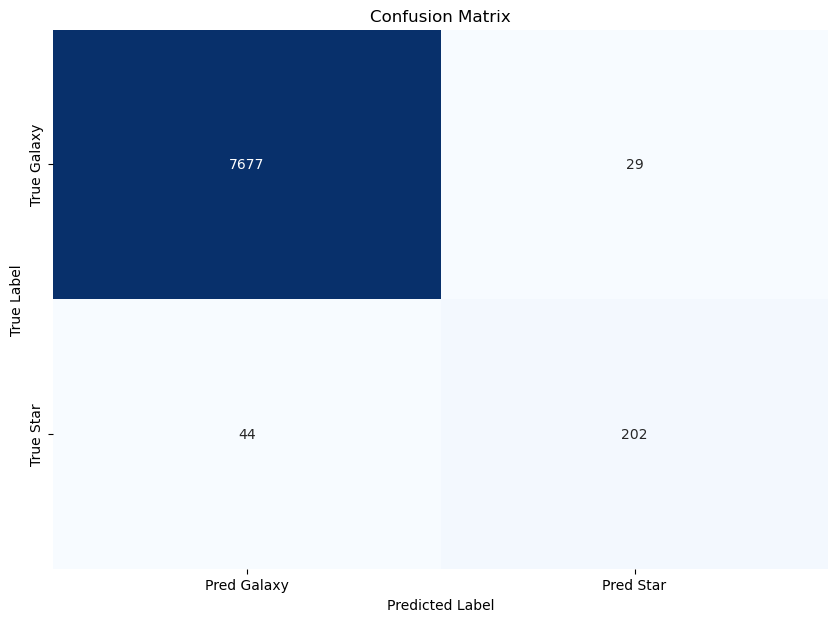

In [14]:
metrics_df_v2, all_matched_gts, _, TP_by_class_mag, pred_tots_by_class_mag, gt_tots_by_class_mag, mag_bins = get_metricsv2(data, reader, predictor, roman_key_mapper)

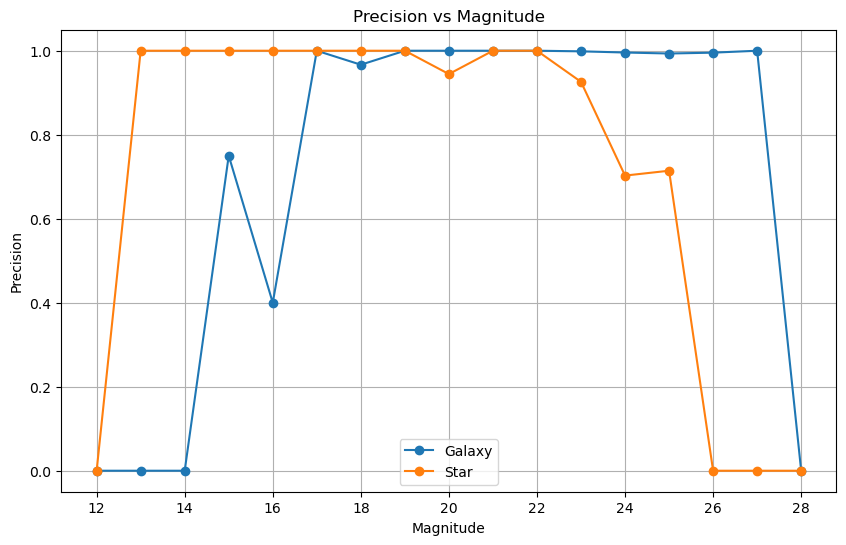

In [15]:
plot_precision_vs_magnitude(TP_by_class_mag, pred_tots_by_class_mag, gt_tots_by_class_mag, mag_bins, run_dir)

In [51]:
mag_types = ['fmag', 'ymag', 'jmag', 'hmag']
filenames = []
idx_mags = []
class_ids = []
bands = []
with open('roman_data/annotations/test_roman.json', 'r') as f:
    test = json.load(f)
for i, d in enumerate(test):
    for ann in d['annotations']:
        for mag in mag_types:
            if ann[mag] < 11:
                filenames.append(d['file_name'])
                idx_mags.append((i, ann['obj_id'], ann[mag]))
                class_ids.append(ann['category_id'])
                bands.append(mag)
filenames_set = set(filenames)
weird_mags = pd.DataFrame({"filenames": filenames, "indices": idx_mags, "class": class_ids, "mags": mag})
print(filenames_set, "\n")
# print(idx_mags)
weird_mags
# all_mags = [ann[mag_type] for d in data for ann in d['annotations'] if mag_type in ann]

{'./roman_data/truth/dc2_54.24_-38.3/full_c280_54.24_-38.3.npy', './roman_data/truth/dc2_53.75_-38.9/full_c242_53.75_-38.9.npy', './roman_data/truth/dc2_54.24_-38.3/full_c57_54.24_-38.3.npy', './roman_data/truth/dc2_54.24_-38.3/full_c111_54.24_-38.3.npy', './roman_data/truth/dc2_53.75_-38.9/full_c153_53.75_-38.9.npy', './roman_data/truth/dc2_53.75_-38.9/full_c122_53.75_-38.9.npy', './roman_data/truth/dc2_54.24_-38.3/full_c24_54.24_-38.3.npy', './roman_data/truth/dc2_54.24_-38.3/full_c170_54.24_-38.3.npy', './roman_data/truth/dc2_54.24_-38.3/full_c226_54.24_-38.3.npy', './roman_data/truth/dc2_54.31_-41.6/full_c44_54.31_-41.6.npy', './roman_data/truth/dc2_53.75_-38.9/full_c139_53.75_-38.9.npy', './roman_data/truth/dc2_53.75_-38.9/full_c203_53.75_-38.9.npy', './roman_data/truth/dc2_54.24_-38.3/full_c85_54.24_-38.3.npy', './roman_data/truth/dc2_54.24_-38.3/full_c238_54.24_-38.3.npy', './roman_data/truth/dc2_54.31_-41.6/full_c155_54.31_-41.6.npy', './roman_data/truth/dc2_54.31_-41.6/full_c2

,filenames,indices,class,mags
0,./roman_data/truth/dc2_54.24_-38.3/full_c238_5...,"(3, 12327, 0.0)",1,hmag
1,./roman_data/truth/dc2_54.31_-41.6/full_c85_54...,"(20, 4654, 0.0)",1,hmag
2,./roman_data/truth/dc2_54.31_-41.6/full_c85_54...,"(20, 4654, 0.0)",1,hmag
3,./roman_data/truth/dc2_54.24_-38.3/full_c57_54...,"(26, 2774, 0.0)",1,hmag
4,./roman_data/truth/dc2_54.31_-41.6/full_c155_5...,"(59, 8726, 0.0)",1,hmag
5,./roman_data/truth/dc2_54.31_-41.6/full_c155_5...,"(59, 8726, 0.0)",1,hmag
6,./roman_data/truth/dc2_54.24_-38.3/full_c85_54...,"(63, 4433, 0.0)",1,hmag
7,./roman_data/truth/dc2_54.24_-38.3/full_c24_54...,"(101, 1613, 0.0)",1,hmag
8,./roman_data/truth/dc2_54.24_-38.3/full_c24_54...,"(101, 1790, 0.0)",1,hmag
9,./roman_data/truth/dc2_53.75_-38.9/full_c242_5...,"(103, 13836, 0.0)",1,hmag


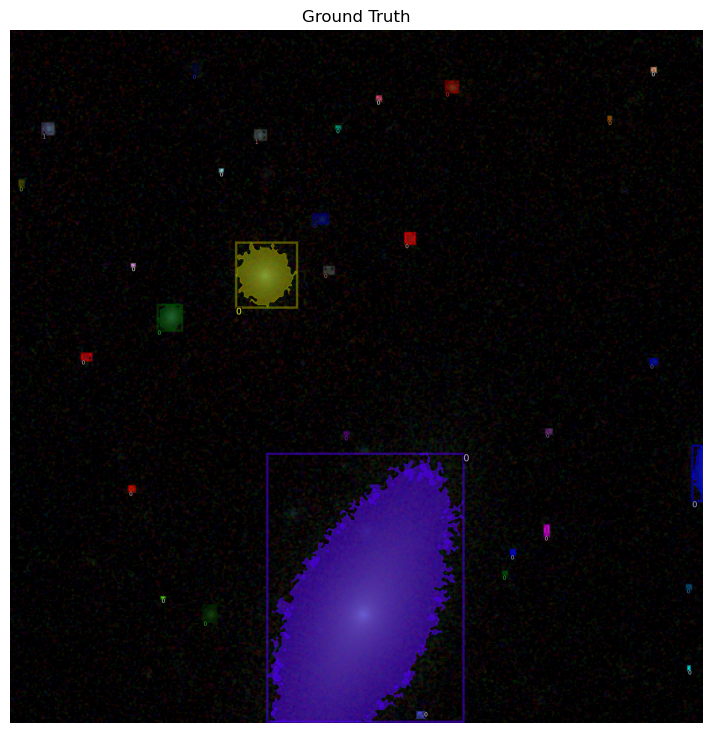

In [45]:
from astropy.visualization import make_lupton_rgb
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode

def plot_weird_cutout(file, img_dict):
    plt.figure(figsize=(9,9))    
    plt.axis("off")
    img = np.load(file)
    img = np.transpose(img, axes=(1,2,0)).astype(np.float32)
    img = make_lupton_rgb(img[:,:,0], img[:,:,1], img[:,:,2], minimum=0, stretch=50, Q=10)
    weird = Visualizer(
        img,
        scale=5,
        instance_mode=ColorMode.IMAGE,
    )
    plt.title("Ground Truth")
    ground_truth = weird.draw_dataset_dict(img_dict)
    plt.imshow(ground_truth.get_image())

for _, fi, indices in weird_mags.itertuples():
    plot_weird_cutout(fi, test[indices[0]])
    break
    def draw_dataset_dict(self, dic):
        """
        Draw annotations/segmentations in Detectron2 Dataset format.

        Args:
            dic (dict): annotation/segmentation data of one image, in Detectron2 Dataset format.

        Returns:
            output (VisImage): image object with visualizations.
        """
        annos = dic.get("annotations", None)
        if annos:
            if "segmentation" in annos[0]:
                masks = [x["segmentation"] for x in annos]
            else:
                masks = None
            if "keypoints" in annos[0]:
                keypts = [x["keypoints"] for x in annos]
                keypts = np.array(keypts).reshape(len(annos), -1, 3)
            else:
                keypts = None

            boxes = [
                (
                    BoxMode.convert(x["bbox"], x["bbox_mode"], BoxMode.XYXY_ABS)
                    if len(x["bbox"]) == 4
                    else x["bbox"]
                )
                for x in annos
            ]

            colors = None
            category_ids = [x["category_id"] for x in annos]
            if self._instance_mode == ColorMode.SEGMENTATION and self.metadata.get("thing_colors"):
                colors = [
                    self._jitter([x / 255 for x in self.metadata.thing_colors[c]])
                    for c in category_ids
                ]
            names = self.metadata.get("thing_classes", None)
            labels = _create_text_labels(
                category_ids,
                scores=None,
                class_names=names,
                is_crowd=[x.get("iscrowd", 0) for x in annos],
            )
            self.overlay_instances(
                labels=labels, boxes=boxes, masks=masks, keypoints=keypts, assigned_colors=colors
            )

        sem_seg = dic.get("sem_seg", None)
        if sem_seg is None and "sem_seg_file_name" in dic:
            with PathManager.open(dic["sem_seg_file_name"], "rb") as f:
                sem_seg = Image.open(f)
                sem_seg = np.asarray(sem_seg, dtype="uint8")
        if sem_seg is not None:
            self.draw_sem_seg(sem_seg, area_threshold=0, alpha=0.5)

        pan_seg = dic.get("pan_seg", None)
        if pan_seg is None and "pan_seg_file_name" in dic:
            with PathManager.open(dic["pan_seg_file_name"], "rb") as f:
                pan_seg = Image.open(f)
                pan_seg = np.asarray(pan_seg)
                from panopticapi.utils import rgb2id

                pan_seg = rgb2id(pan_seg)
        if pan_seg is not None:
            segments_info = dic["segments_info"]
            pan_seg = torch.tensor(pan_seg)
            self.draw_panoptic_seg(pan_seg, segments_info, area_threshold=0, alpha=0.5)
        return self.output

In [ ]:
plot_mag_v_pr(data, reader, predictor, roman_key_mapper, run_dir)

In [ ]:
## issue with some segmentations having empty lists AKA no polygons AKA no area/small area
## temp fix: put placeholder segms based on bounding box coords
## permanent fix: change get_metadata function to have minimum area or discard any with 0 area?
# no polygon remove it in get metadata
corrected_data = data
def fix_annotations(annotations):
    fixed_annos = []
    for ann in annotations:
        if ann['segmentation']:
            fixed_annos.append(ann)
        else:
            x, y, w, h = ann['bbox']
            min_polygon = [x, y, x, y+h, x+w, y+h, x+w, y]
            ann['segmentation'] = [min_polygon]
            fixed_annos.append(ann)
    return fixed_annos

for ent in corrected_data:
    ent['annotations'] = fix_annotations(ent['annotations'])

# corrected_data[1]['annotations'][83]

from deepdisc.data_format.conversions import convert_to_json
output_file = './roman_data/annotations/test_roman_corrected.json'
convert_to_json(corrected_data, output_file)

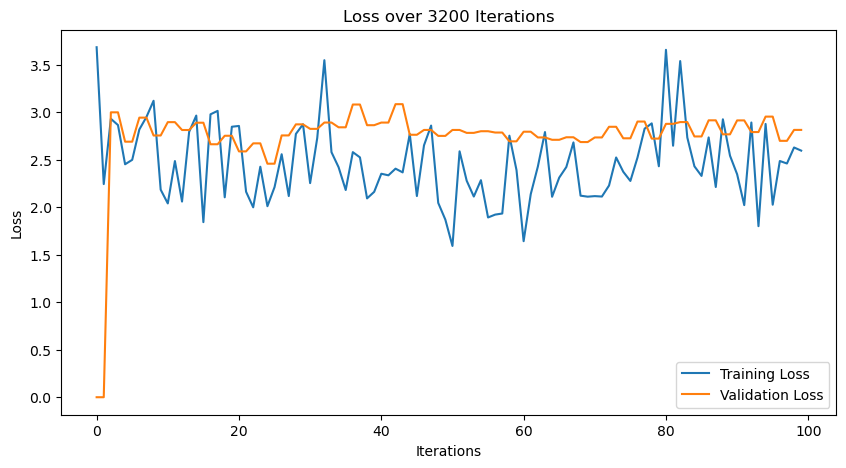

In [42]:
import torch
import matplotlib.pyplot as plt
import detectron2.checkpoint as checkpointer
# checkpoint_cls = checkpointer.DetectionCheckpointer("roman_runs/first_official_test.pth")
# cp = checkpoint_cls.load("roman_runs/last_checkpoint.pth")
def parse_losses(log_file_path):
    training_losses = []
    validation_losses = []
    with open(log_file_path, 'r') as file:
        for line in file:
            if "Iteration:" in line:
                parts = line.split()
#                 print(parts)
                total_loss = 0        
                for loss in parts[parts.index('\'loss_rpn_loc\'])') + 1 : parts.index('val')]:
                    tmp_loss = []    
                    if "[" in loss:
                        tmp_loss.append(float(loss[1:-1]))
                    else:
                        tmp_loss.append(float(loss[:-1]))
                    total_loss += sum(tmp_loss)
                val_loss_index = parts.index('loss:') + 1
                validation_losses.append(float(parts[val_loss_index]))
                training_losses.append(total_loss)
    return training_losses, validation_losses

train_losses, val_losses = parse_losses('training_deepdisc_out.179802.hal03.out')

# Plot the loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss over 3200 Iterations')
plt.legend()

In [1]:
import os, csv

ras_decs = []
with open("original_img_file_names.csv", 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        ra, dec = map(float, row)
        ras_decs.append((ra, dec))

In [4]:
ras_decs

[(53.25, -41.8),
 (53.75, -38.9),
 (52.93, -40.8),
 (53.0, -40.6),
 (56.06, -39.8),
 (55.8, -38.0),
 (51.37, -38.3),
 (52.5, -41.3),
 (54.31, -41.6),
 (52.31, -41.6),
 (51.34, -41.3),
 (54.24, -38.3),
 (51.53, -40.0),
 (54.4, -38.3),
 (55.03, -41.9)]

In [12]:
import os
import fnmatch
import json
json_filenames = [f for f in os.listdir('roman_data/annotations/') if fnmatch.fnmatch(f, '*.json')]
all_metadata = {}
for name in json_filenames:
    full_path = 'roman_data/annotations/' + name
    with open(full_path, 'r') as f:
        data = json.load(f)
        all_metadata[name[:-5]] = data

from deepdisc.data_format.conversions import convert_to_json
output_file = './test.json'
convert_to_json(all_metadata, output_file) # filename in dict

Caching COCO format annotations at './test.json' ...


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(trainer.lossList, label=r"$L_{\rm{tot}}$")
# ax.plot(losses, label=r'$L_{\rm{tot}}$')

ax.legend(loc="upper right")
ax.set_xlabel("training epoch", fontsize=20)
ax.set_ylabel("loss", fontsize=20)
fig.tight_layout()

In [30]:
import numpy as np
img_cutout_data = 'roman_data/truth/dc2_50.93_-42.0/full_c2_50.93_-42.0.npy'
test = np.load(img_cutout_data)

a = [[0,1,2], [3,4,5]]
a = np.asarray(a)

np_array_3d= np.asarray([
                         [     
                            [0,1,2], # 0 + 0 + 0 is row collapse, # 
                            [3,4,5], 
                            [6,7,9]
                         ],
                         [
                            [0,1,2], 
                            [3,4,5], 
                            [6,7,8]
                         ],
                         [
                            [0,1,2], 
                            [3,4,5],
                            [6,7,8]
                         ]
                        ])

sum_3d = np.sum(np_array_3d, axis = (2))
means_arr = np.empty((2, 1, 4))
print(np_array_3d.shape)
print(sum_3d.shape)
print(sum_3d)
arr = np.asarray([[]])
sum_arr = np.sum(np_array_3d, axis = (0,1))
# arr = np.append(arr, sum_arr)
# arr = np.append(arr, sum_arr, axis=0)
# arr
sum_arr.shape

(3, 3, 3)
(3, 3)
[[ 3 12 22]
 [ 3 12 21]
 [ 3 12 21]]


(3,)

### NP Indexing

https://towardsdatascience.com/a-visual-guide-to-multidimensional-numpy-array-aggregation-97a8960b3c59

a = [[0 1 2] # 2D Arr (rows = 2, columns = 3)
[3 4 5]]


np.sum(a, axis = 0) collapses the rows (axis=0) and then sums
so we get 0 + 3, 1 + 4, 2 + 5 --> 3, 5, 7 (same shape as columns)

same as above but with axis=1 collapses the columns (axis = 1) and then sums
so we get 0 + 1 + 2, 3 + 4 + 5 --> 3, 12 (same shape as rows)

thus axis = # indicates the dimension which will collapse and then the remaining dimensions are what will store the result of the operation **SETTING PARAM ELIMINATES THAT SPECIFIC DIMENSION**

WITH ND, **indexing always starts with the highest dimension**. With each added dimension, the new dimension gets index 0 and all other indices are increased by one.

np_array_3d= np.asarray([[[0,1,2],[3,4,5],[6,7,8]],
                        [[0,1,2],[3,4,5],[6,7,8]],
                        [[0,1,2],[3,4,5],[6,7,8]]])
So, here the highest dimension is the dimension of the layers so it's the 0th dimension. The next two dims are the rows and cols we're familiar with.

sum_3d = np.sum(np_array_3d, axis = (0)) collapses the layers (axis=0) and then sums so we get 
[[0,3,6]. [9,12,15], [18, 21, 24]] (row = 3 x col = 3) 

sum_3d = np.sum(np_array_3d, axis = (1)) collapses the rows (axis=1) and then sums so we get 
[[9,12,15]. [9,12,15], [9,12,15]] from (3,3,3) --> (3,1,3) --> (3,3) where this falls into the previous case of 2d arrs

axis=2 collapse the same way

np.sum(np_array_3d, axis = (0,1)) collapses the layers and the rows and then sums so we get
[27]. [36], [45] from (3, 3, 3) --> (1,3,3) --> (1,1,3) --> (1,3)

In [5]:
import torch
torch.cuda.device_count()
# checkpoint_t = torch.load("./roman_runs/run2/all_roman.pth") #, map_location=torch.device('cuda'))
# torch.cuda.empty_cache()


2

In [2]:
!nvidia-smi

Mon Jun 24 04:38:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-16GB           On  |   00000004:05:00.0 Off |                    0 |
| N/A   37C    P0             40W /  300W |       1MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
torch.cuda.empty_cache()

In [4]:
!python run_model.py --cfgfile ./deepdisc/configs/solo/solo_swin_focal.py --train-metadata roman_data/annotations/train_roman.json --eval-metadata roman_data/annotations/val_roman.json --num-gpus 1 --run-name swin_focal --output-dir .

Command Line Args: Namespace(cfgfile='./deepdisc/configs/solo/solo_swin_focal.py', config_file='', train_metadata='roman_data/annotations/train_roman.json', eval_metadata='roman_data/annotations/val_roman.json', eval_only=False, from_scratch=False, output_dir='.', resume=False, run_name='swin_focal', num_gpus=1, num_machines=1, machine_rank=0, A=1000.0, alphas=None, cp=99.99, do_fl=False, do_norm=False, dtype=8, modname='swin', norm='raw', Q=10, scheme=1, stretch=0.5, tl=1, dist_url='tcp://127.0.0.1:54640', opts=[])
Training head layers
Running on GPUs:
[06/24 16:05:54 d2.data.build]: Removed 2 images with no usable annotations. 2349 images left.
[06/24 16:05:54 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   galaxy   | 92321        |    star    | 1636         |
|            |              |            |              |
|   total    | 93957        |  

In [13]:
def plot_precision_vs_magnitude(test_data, predictor, imreader, key_mapper, run_dir):
    # Define magnitude bins
    min_mag = min(ann['fmag'] for d in test_data for ann in d['annotations'])
    max_mag = max(ann['fmag'] for d in test_data for ann in d['annotations'])
    mag_bins = np.linspace(min_mag, max_mag, 20)  # Adjust the number of bins as necessary

    # Initialize arrays to hold precision values for stars and galaxies
    precision_data = {'star': [], 'galaxy': []}
    magnitude_midpoints = []

    for i in range(len(mag_bins) - 1):
        mag_low, mag_high = mag_bins[i], mag_bins[i + 1]
        TP = {'star': 0, 'galaxy': 0}
        total = {'star': 0, 'galaxy': 0}

        for d in test_data:
            annotations = [ann for ann in d['annotations'] if mag_low <= ann['fmag'] < mag_high]
            if not annotations:
                continue
            
            outputs = get_predictions(d, imreader, key_mapper, predictor)
            gt_boxes = [ann['bbox'] for ann in annotations]
            gt_classes = [ann['category_id'] for ann in annotations]

            if gt_boxes:
                gt_boxes = np.array(gt_boxes)
                gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
                gt_boxes = structures.Boxes(torch.Tensor(gt_boxes))
                pred_boxes = outputs['instances'].pred_boxes.to("cpu")
                
                IOUs = structures.pairwise_iou(pred_boxes, gt_boxes).numpy()
                matched_indices = np.argmax(IOUs, axis=1)
                best_IOUs = np.max(IOUs, axis=1)
                
                for idx, (best_iou, match_idx) in enumerate(zip(best_IOUs, matched_indices)):
                    if best_iou >= 0.5:
                        category = 'star' if gt_classes[match_idx] == 1 else 'galaxy'
                        TP[category] += 1
                        total[category] += 1

        # Calculate precision for this magnitude bin
        for category in ['star', 'galaxy']:
            if total[category] > 0:
                precision_data[category].append(TP[category] / total[category])
            else:
                precision_data[category].append(0)
        magnitude_midpoints.append((mag_low + mag_high) / 2)

    # Plotting
#     plt.figure(figsize=(12, 6))
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    for idx, category in enumerate(['star', 'galaxy']):
        axs[idx].plot(magnitude_midpoints, precision_data[category], label=f'{category.capitalize()} Precision', marker='o')
        axs[idx].set_title(f'Precision as a Function of Magnitude for {category.capitalize()}s')
        axs[idx].set_xlabel('Magnitude')
        axs[idx].set_ylabel('Precision')
        axs[idx].grid(True)
        axs[idx].set_ylim(0, 1.05)
        axs[idx].set_xlim(min_mag, max_mag)
#     for category in ['star', 'galaxy']:
#         plt.plot(magnitude_midpoints, precision_data[category], label=f'{category.capitalize()} Precision', marker='o')
    plt.legend()
    plt.tight_layout()
    
#     output_path = os.path.join(run_dir, "precision_vs_magnitude.png")
#     plt.savefig(output_path)
#     plt.show()
#     print(f"Precision vs Magnitude plot saved to {output_path}")

In [ ]:
plot_precision_vs_magnitude(data, predictor, reader, roman_key_mapper, run_dir)

In [15]:
def plot_all_precision_vs_magnitude(test_data, predictor, imreader, key_mapper, run_dir):
    # Define different magnitude types
    mag_types = ['fmag', 'ymag', 'jmag', 'hmag']
    colors = plt.cm.viridis(np.linspace(0, 1, len(mag_types)))
    # Initialize a single figure to hold all subplots
    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle('Precision as a Function of Different Magnitudes')
        # Process each magnitude type
    
    for mag_idx, mag_type in enumerate(mag_types):
        # Define magnitude bins based on current magnitude type
        min_mag = min(ann[mag_type] for d in test_data for ann in d['annotations'] if mag_type in ann)
        max_mag = max(ann[mag_type] for d in test_data for ann in d['annotations'] if mag_type in ann)
        mag_bins = np.linspace(min_mag, max_mag, 10)  # Adjust the number of bins as necessary
        precision_data = {'star': [], 'galaxy': []}
        magnitude_midpoints = []

        for i in range(len(mag_bins) - 1):
            mag_low, mag_high = mag_bins[i], mag_bins[i + 1]
            TP = {'star': 0, 'galaxy': 0}
            total = {'star': 0, 'galaxy': 0}

            for d in test_data:
                annotations = [ann for ann in d['annotations'] if mag_low <= ann[mag_type] < mag_high if mag_type in ann]
                if not annotations:
                    continue

                outputs = get_predictions(d, imreader, key_mapper, predictor)
                gt_boxes = [ann['bbox'] for ann in annotations]
                gt_classes = [ann['category_id'] for ann in annotations]

                if gt_boxes:
                    gt_boxes = np.array(gt_boxes)
                    gt_boxes = BoxMode.convert(gt_boxes, BoxMode.XYWH_ABS, BoxMode.XYXY_ABS)
                    gt_boxes = structures.Boxes(torch.Tensor(gt_boxes))
                    pred_boxes = outputs['instances'].pred_boxes.to("cpu")

                    IOUs = structures.pairwise_iou(pred_boxes, gt_boxes).numpy()
                    matched_indices = np.argmax(IOUs, axis=1)
                    best_IOUs = np.max(IOUs, axis=1)

                    for idx, (best_iou, match_idx) in enumerate(zip(best_IOUs, matched_indices)):
                        if best_iou >= 0.5:
                            category = 'star' if gt_classes[match_idx] == 1 else 'galaxy'
                            TP[category] += 1
                            total[category] += 1

            # Calculate precision for this magnitude bin
            for category in ['star', 'galaxy']:
                if total[category] > 0:
                    precision_data[category].append(TP[category] / total[category])
                else:
                    precision_data[category].append(0)
            magnitude_midpoints.append((mag_low + mag_high) / 2)

        # Plotting for each category
        for idx, category in enumerate(['star', 'galaxy']):
            axs[idx].plot(magnitude_midpoints, precision_data[category], label=f'{mag_type.capitalize()} Precision', 
                          color=colors[mag_idx], marker='o')
            axs[idx].set_title(f'{category.capitalize()}')
            axs[idx].set_xlabel('Magnitude')
            axs[idx].set_ylabel('Precision')
            axs[idx].legend()
            axs[idx].grid(True)
            axs[idx].set_ylim(0, 1.05)
            axs[idx].set_xlim(min_mag, max_mag)
    
    plt.tight_layout()


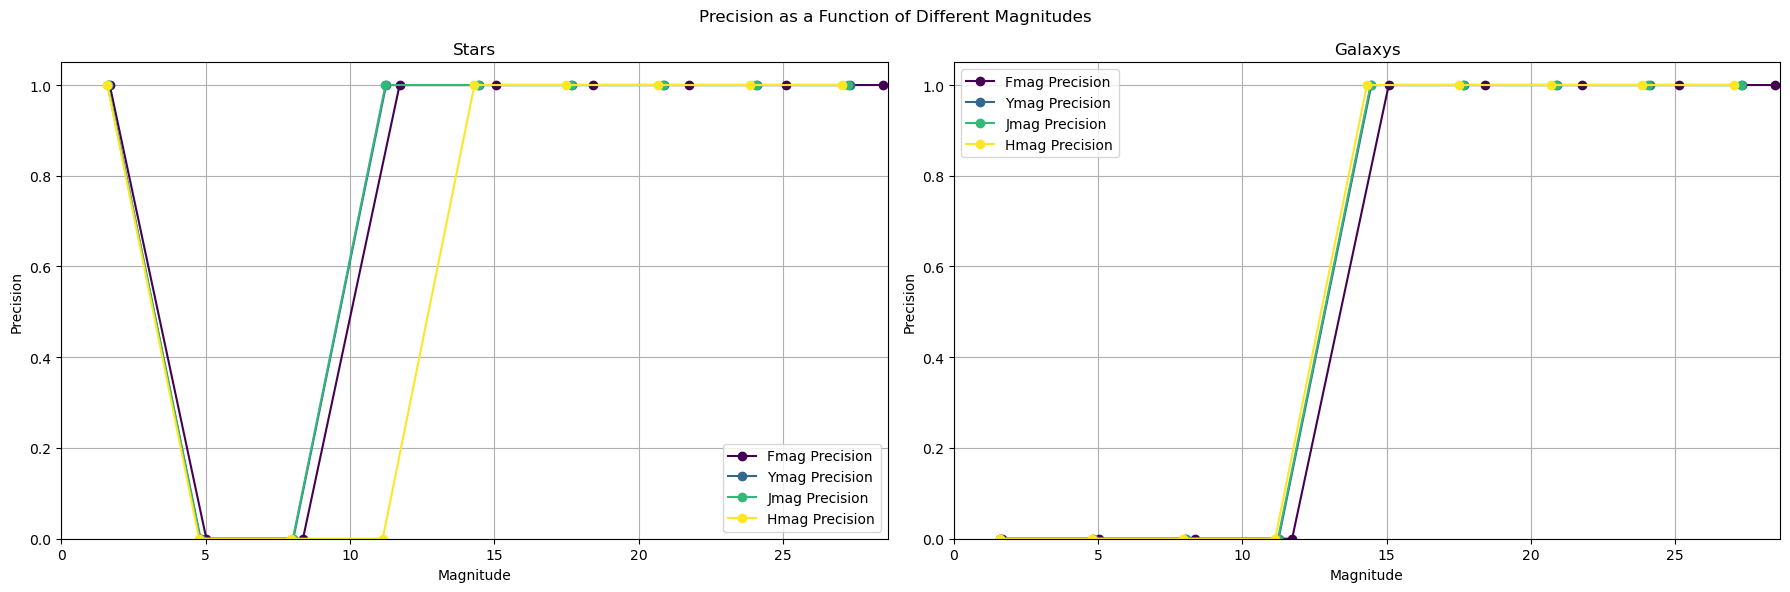

In [14]:
plot_all_precision_vs_magnitude(data, predictor, reader, roman_key_mapper, run_dir)